In [2]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
#from kaggle_datasets import KaggleDatasets
import transformers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from tokenizers import BertWordPieceTokenizer

Using TensorFlow backend.


In [3]:
train1 = pd.read_csv("./jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
valid = pd.read_csv('./jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('./jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('./jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [4]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [5]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 5
BATCH_SIZE = 32
MAX_LEN = 192

In [6]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=False, wordpieces_prefix=##)

In [7]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

100%|██████████| 250/250 [00:04<00:00, 50.59it/s]


In [8]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [9]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [11]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 192, 768),)       134734080 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________
Wall time: 4.53 s


In [12]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Train for 6985 steps, validate for 250 steps
Epoch 1/5
6985/6985 [==============================] - 6641s 951ms/step - loss: 0.1154 - accuracy: 0.9540 - val_loss: 0.4445 - val_accuracy: 0.8489
Epoch 2/5
6985/6985 [==============================] - 6648s 952ms/step - loss: 0.0854 - accuracy: 0.9650 - val_loss: 0.5604 - val_accuracy: 0.8503
Epoch 3/5
6985/6985 [==============================] - 6632s 949ms/step - loss: 0.0670 - accuracy: 0.9719 - val_loss: 0.6318 - val_accuracy: 0.8535
Epoch 4/5
6985/6985 [==============================] - 6644s 951ms/step - loss: 0.0485 - accuracy: 0.9799 - val_loss: 0.6189 - val_accuracy: 0.8540
Epoch 5/5
6985/6985 [==============================] - 6645s 951ms/step - loss: 0.0341 - accuracy: 0.9866 - val_loss: 0.7668 - val_accuracy: 0.8574


In [19]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

Train for 250 steps
Epoch 1/10
250/250 [==============================] - 233s 934ms/step - loss: 0.3102 - accuracy: 0.8699
Epoch 2/10
250/250 [==============================] - 234s 934ms/step - loss: 0.2011 - accuracy: 0.9149
Epoch 3/10
250/250 [==============================] - 234s 935ms/step - loss: 0.1221 - accuracy: 0.9507
Epoch 4/10
250/250 [==============================] - 235s 938ms/step - loss: 0.0738 - accuracy: 0.9741
Epoch 5/10
250/250 [==============================] - 234s 937ms/step - loss: 0.0511 - accuracy: 0.9811
Epoch 6/10
250/250 [==============================] - 234s 938ms/step - loss: 0.0366 - accuracy: 0.9875
Epoch 7/10
250/250 [==============================] - 235s 939ms/step - loss: 0.0181 - accuracy: 0.9931
Epoch 8/10
250/250 [==============================] - 235s 939ms/step - loss: 0.0108 - accuracy: 0.9962
Epoch 9/10
250/250 [==============================] - 235s 939ms/step - loss: 0.0070 - accuracy: 0.9975
Epoch 10/10
250/250 [=======================

In [20]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
  
    return roc_auc

In [33]:
#train2 = pd.read_csv("./jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv")
valid = pd.read_csv('./jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv')

In [34]:
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)

100%|██████████| 32/32 [00:00<00:00, 56.71it/s]


In [35]:
y_valid = valid.toxic.values

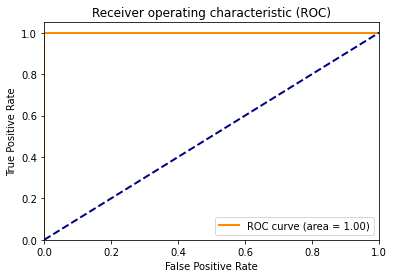

1.0


In [36]:
scores = model.predict(x_valid)
BERT_score = roc_auc(scores,y_valid)
#scores_model.append({'Model': 'BERT','AUC_Score': BERT_score})
print(BERT_score)

In [26]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

1995/1995 [==============================] - 563s 282ms/step


In [31]:
model.save_weights('BERT_model.h5')